<a href="https://colab.research.google.com/github/Ivan-Nebogatikov/HumanActivityRecognition/blob/master/DatasetMethodsComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
from datetime import date
from math import sqrt

def getValue(x):
    l = list(json.loads(x.replace('\'', '"')))
    return l

def getDiff(x):
    res = list()
    for i, v in enumerate(x):
        res.append(v)
        #if i > 0:
        #    res.append(v - x[i - 1])
        #else:
        #    res.append(0)
    return res

features = pd.read_csv('https://raw.githubusercontent.com/Ivan-Nebogatikov/HumanActivityRecognition/master/datasets/WinterDataset/dataset.csv', sep=r'\s*,\s*')
features = features.drop('STATE', axis=1)
print(features)
activities = list(sorted(set(features['ACT'])))
print("Activities:", activities)

labels = np.array(features['ACT'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


        HR  SC  WF  BT        ACT
0        0   0 -73 -54        eat
1        0   0 -76 -39        eat
2        0   0 -73 -27        eat
3        0   0 -71 -27        eat
4        0   0 -73 -27        eat
...    ...  ..  ..  ..        ...
26704  110   0 -53 -45  household
26705  112   0 -53 -40  household
26706  113   0 -53 -40  household
26707  113   0 -53 -40  household
26708  113   0 -53 -37  household

[26709 rows x 5 columns]
Activities: ['eat', 'household', 'inactive', 'preparing_food', 'shower', 'sport', 'videogames', 'walk', 'work']


In [3]:
import pandas as pd
import numpy as np
from scipy import interp

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = 5
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    print(class_report_df)
    return accuracy

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

def Predict(x, classifier = RandomForestClassifier(n_estimators = 400, random_state = 3, class_weight='balanced')):
    train_features, test_features, train_labels, test_labels = train_test_split(x, labels, test_size = 0.15, random_state = 242)
    print('Training Features Shape:', train_features.shape)
    print('Testing Features Shape:', test_features.shape)
    print("\n")

    classifier.fit(train_features, train_labels);

    x_shuffled, labels_shuffled = shuffle(np.array(x), np.array(labels))
    scores = cross_val_score(classifier, x_shuffled, labels_shuffled, cv=10)
    print("%f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    predictions = list(classifier.predict(test_features))
    pred_prob = classifier.predict_proba(test_features)

    accuracy = class_report(
        y_true=test_labels, 
        y_pred=np.asarray(predictions), 
        y_score=pred_prob, average='micro')
    
    if hasattr(classifier, 'feature_importances_'):
      print(classifier.feature_importances_)

    print(confusion_matrix(test_labels, predictions, normalize='true'))
    np.set_printoptions(precision=4)  
    np.set_printoptions(suppress=True)
    plot_confusion_matrix(classifier, test_features, test_labels, normalize='true')
    plt.xticks(rotation = 90)
    plt.style.library['seaborn-darkgrid']
    plt.show()

    return [accuracy, scores.mean(), scores.std()]

def PredictWithClassifiers(data, classifiers):
    accuracies = {}
    for name, value in classifiers.items():
        accuracy = Predict(data, value)
        accuracies[name] = accuracy
        print("\n")
    df = pd.DataFrame({(k, v[0], v[1], v[2]) for k, v in accuracies.items()}, columns=["Method", "Accuracy", "Mean", "Std"])
    print(df)

In [8]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import AdaBoostClassifier

methods = {
    "MLP" : MLPClassifier(random_state=1, max_iter=300),
    "K-neigh" : KNeighborsClassifier(), # default k = 5
    "Random Forest" : RandomForestClassifier(n_estimators = 400, random_state = 3, class_weight='balanced'),
    "Bayes" : GaussianNB(),
    "AdaBoost" : AdaBoostClassifier(),
    "SVM" : svm.SVC(probability=True, class_weight='balanced')
}

Training Features Shape: (22702, 4)
Testing Features Shape: (4007, 4)


0.743196 accuracy with a standard deviation of 0.01
Accuracy: 0.7392063888195658
                precision    recall  f1-score  support    pred       AUC
eat              0.484375  0.436620  0.459259    213.0   192.0  0.916992
household        0.907104  0.959538  0.932584    173.0   183.0  0.999326
inactive         0.859310  0.916176  0.886833    680.0   725.0  0.984035
preparing_food   0.719577  0.814371  0.764045    167.0   189.0  0.990510
shower           0.905579  0.483945  0.630792    436.0   233.0  0.946058
sport            0.482759  0.191781  0.274510     73.0    29.0  0.917220
videogames       0.655374  0.794618  0.718310    706.0   856.0  0.945875
walk             0.408602  0.305835  0.349827    497.0   372.0  0.819987
work             0.819218  0.947269  0.878603   1062.0  1228.0  0.975372
avg / total      0.731334  0.739206  0.723467   4007.0  4007.0  0.964548
[[0.4366 0.     0.     0.0141 0.0047 0.0094 

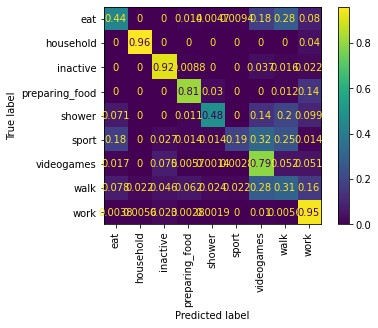



Training Features Shape: (22702, 4)
Testing Features Shape: (4007, 4)


0.815830 accuracy with a standard deviation of 0.01
Accuracy: 0.8145744946343898
                precision    recall  f1-score  support    pred       AUC
eat              0.515385  0.629108  0.566596    213.0   260.0  0.930579
household        1.000000  1.000000  1.000000    173.0   173.0  1.000000
inactive         0.845517  0.901471  0.872598    680.0   725.0  0.971040
preparing_food   1.000000  0.994012  0.996997    167.0   166.0  0.997005
shower           0.823113  0.800459  0.811628    436.0   424.0  0.954741
sport            0.578947  0.452055  0.507692     73.0    57.0  0.867420
videogames       0.723958  0.787535  0.754410    706.0   768.0  0.939105
walk             0.691877  0.496982  0.578454    497.0   357.0  0.882026
work             0.922006  0.935028  0.928471   1062.0  1077.0  0.984037
avg / total      0.813580  0.814574  0.811236   4007.0  4007.0  0.962201
[[0.6291 0.     0.0094 0.     0.0939 0.028

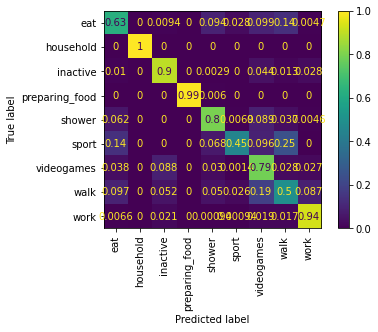



Training Features Shape: (22702, 4)
Testing Features Shape: (4007, 4)


0.825340 accuracy with a standard deviation of 0.01
Accuracy: 0.8243074619416022
                precision    recall  f1-score  support    pred       AUC
eat              0.487879  0.755869  0.593002    213.0   330.0  0.964354
household        1.000000  1.000000  1.000000    173.0   173.0  1.000000
inactive         0.877292  0.914706  0.895608    680.0   709.0  0.988319
preparing_food   1.000000  1.000000  1.000000    167.0   167.0  1.000000
shower           0.871795  0.779817  0.823245    436.0   390.0  0.986023
sport            0.304094  0.712329  0.426230     73.0   171.0  0.974481
videogames       0.788018  0.726629  0.756080    706.0   651.0  0.964942
walk             0.767760  0.565392  0.651217    497.0   366.0  0.926623
work             0.946667  0.935970  0.941288   1062.0  1050.0  0.994015
avg / total      0.845035  0.824307  0.829166   4007.0  4007.0  0.985095
[0.3457 0.     0.4851 0.1692]
[[0.7559 0. 

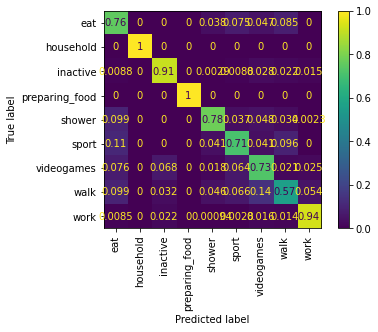



Training Features Shape: (22702, 4)
Testing Features Shape: (4007, 4)


0.686810 accuracy with a standard deviation of 0.01
Accuracy: 0.6765660094834041
                precision    recall  f1-score  support    pred       AUC
household        0.699187  0.994220  0.821002    173.0   246.0  0.001755
inactive         0.751816  0.913235  0.824701    680.0   826.0  0.154732
preparing_food   1.000000  0.940120  0.969136    167.0   157.0  0.218750
shower           0.976744  0.481651  0.645161    436.0   215.0  0.719873
sport            0.358974  0.383562  0.370861     73.0    78.0  0.735802
videogames       0.425787  0.804533  0.556863    706.0  1334.0  0.672858
walk             0.474576  0.169014  0.249258    497.0   177.0  0.615275
work             0.894251  0.820151  0.855599   1062.0   974.0  0.743147
avg / total      0.683160  0.676566  0.648543   3794.0  3794.0  0.909899
[[0.     0.     0.     0.     0.     0.0892 0.554  0.2817 0.0751]
 [0.     0.9942 0.     0.     0.     0.     0.   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


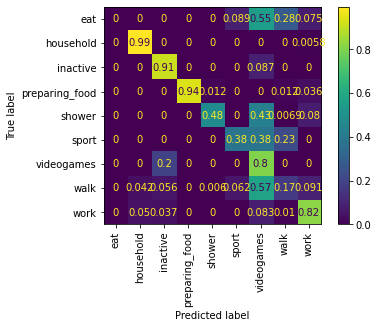



Training Features Shape: (22702, 4)
Testing Features Shape: (4007, 4)


0.456326 accuracy with a standard deviation of 0.01
Accuracy: 0.4564512103818318


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


             precision    recall  f1-score  support    pred       AUC
household     1.000000  1.000000  1.000000    173.0   173.0  0.005999
shower        1.000000  0.052752  0.100218    436.0    23.0  0.366744
videogames    0.254690  1.000000  0.405980    706.0  2772.0  0.687065
work          0.892204  0.872881  0.882437   1062.0  1039.0  0.921655
avg / total   0.433325  0.456451  0.359487   2377.0  2377.0  0.785875
[0.5 0.  0.5 0. ]
[[0.     0.     0.     0.     0.     0.     0.8967 0.     0.1033]
 [0.     1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.0528 0.     0.9404 0.     0.0069]
 [0.     0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.8249 0.     0.1751]
 [0.     0.     0.     0.     0.  

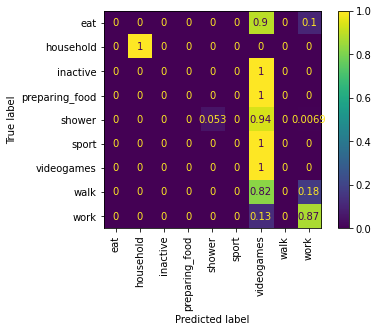



Training Features Shape: (22702, 4)
Testing Features Shape: (4007, 4)


0.690029 accuracy with a standard deviation of 0.01
Accuracy: 0.6790616421262791
                precision    recall  f1-score  support    pred       AUC
eat              0.284936  0.737089  0.410995    213.0   551.0  0.886533
household        0.742489  1.000000  0.852217    173.0   233.0  0.999932
inactive         0.747031  0.925000  0.826544    680.0   842.0  0.951969
preparing_food   0.491749  0.892216  0.634043    167.0   303.0  0.974308
shower           0.875502  0.500000  0.636496    436.0   249.0  0.932401
sport            0.357895  0.465753  0.404762     73.0    95.0  0.947114
videogames       0.592593  0.657224  0.623237    706.0   783.0  0.890230
walk             0.777778  0.014085  0.027668    497.0     9.0  0.773166
work             0.944798  0.838041  0.888224   1062.0   942.0  0.960844
avg / total      0.747540  0.679062  0.650616   4007.0  4007.0  0.948087
[[0.7371 0.     0.     0.0469 0.0188 0.089

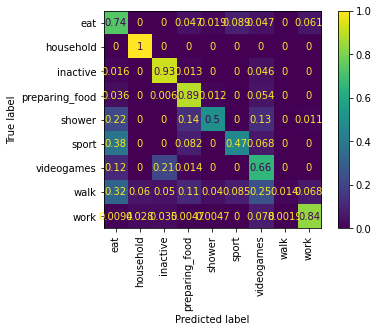



          Method  Accuracy      Mean       Std
0       AdaBoost  0.456451  0.456326  0.005594
1  Random Forest  0.824307  0.825340  0.005072
2        K-neigh  0.814574  0.815830  0.008197
3          Bayes  0.676566  0.686810  0.006239
4            SVM  0.679062  0.690029  0.011057
5            MLP  0.739206  0.743196  0.006144


In [13]:
features2 = features.drop('ACT', axis = 1)

PredictWithClassifiers(features2, methods)